<a href="https://colab.research.google.com/github/mohammadsanaee/ML_in_application/blob/main/13_models_understanding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!rm -rf harbour-space-text-mining-course
!git clone https://github.com/horoshenkih/harbour-space-text-mining-course.git
import sys
sys.path.append('harbour-space-text-mining-course')
!pip install -q catboost
!pip install -q shap

from tmcourse.utils import (
    display_token_importance,
)

from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from IPython.display import HTML, display
import pandas as pd
import seaborn as sns
sns.set(rc={'figure.figsize':(15,10)})

Cloning into 'harbour-space-text-mining-course'...
remote: Enumerating objects: 738, done.
remote: Counting objects: 100% (175/175), done.
remote: Compressing objects: 100% (105/105), done.
remote: Total 738 (delta 79), reused 158 (delta 69), pack-reused 563
Receiving objects: 100% (738/738), 179.50 MiB | 18.75 MiB/s, done.
Resolving deltas: 100% (403/403), done.
Updating files: 100% (129/129), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.9/575.9 KB 10.1 MB/s eta 0:00:00


# Linear models: feature effect

In [2]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer

categories = [
    "alt.atheism",
    "talk.religion.misc",
    "comp.graphics",
    "sci.space",
]
remove = ("headers", "footers", "quotes")

data_train = fetch_20newsgroups(
    subset="train",
    categories=categories,
    shuffle=True,
    random_state=42,
    remove=remove,
)

data_test = fetch_20newsgroups(
    subset="test",
    categories=categories,
    shuffle=True,
    random_state=42,
    remove=remove,
)

# order of labels in `target_names` can be different from `categories`
target_names = data_train.target_names

# split target in a training set and a test set
y_train, y_test = data_train.target, data_test.target

# Extracting features from the training data using a sparse vectorizer

vectorizer = TfidfVectorizer(
    sublinear_tf=True, max_df=0.5, min_df=5, stop_words="english"
)
X_train = vectorizer.fit_transform(data_train.data)


# Extracting features from the test data using the same vectorizer
X_test = vectorizer.transform(data_test.data)

feature_names = vectorizer.get_feature_names_out()

In [3]:
from sklearn.linear_model import RidgeClassifier

clf = RidgeClassifier(tol=1e-2, solver="sparse_cg")
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

top 5 keywords per class:
  alt.atheism comp.graphics sci.space talk.religion.misc
0         don      graphics     space                god
1      people          file      like          christian
2         say        thanks      nasa              jesus
3    religion         image     orbit         christians
4        post          does    launch              wrong


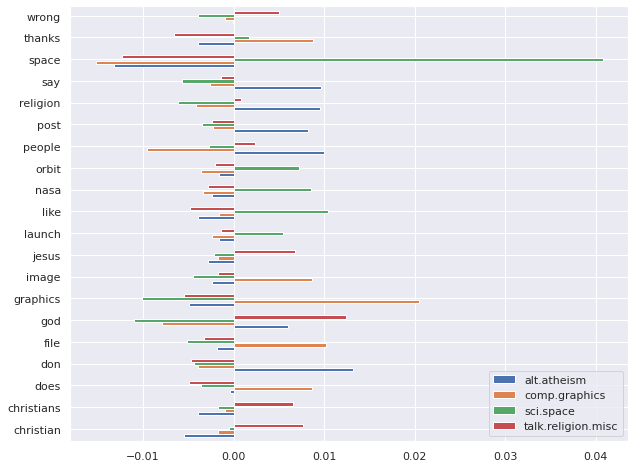

In [4]:
# learned coefficients weighted by frequency of appearance
average_feature_effects = clf.coef_ * np.asarray(X_train.mean(axis=0)).ravel()

for i, label in enumerate(target_names):
    top5 = np.argsort(average_feature_effects[i])[-5:][::-1]
    if i == 0:
        top = pd.DataFrame(feature_names[top5], columns=[label])
        top_indices = top5
    else:
        top[label] = feature_names[top5]
        top_indices = np.concatenate((top_indices, top5), axis=None)
top_indices = np.unique(top_indices)
predictive_words = feature_names[top_indices]

# plot feature effects
bar_size = 0.25
padding = 0.75
y_locs = np.arange(len(top_indices)) * (4 * bar_size + padding)

fig, ax = plt.subplots(figsize=(10, 8))
for i, label in enumerate(target_names):
    ax.barh(
        y_locs + (i - 2) * bar_size,
        average_feature_effects[i, top_indices],
        height=bar_size,
        label=label,
    )
ax.set(
    yticks=y_locs,
    yticklabels=predictive_words,
    ylim=[
        0 - 4 * bar_size,
        len(top_indices) * (4 * bar_size + padding) - 4 * bar_size,
    ],
)
ax.legend(loc="lower right")

print("top 5 keywords per class:")
print(top)

# Feature importance for Random Forest

We generate a synthetic dataset with only 3 informative features.

In [5]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(
    n_samples=1000,
    n_features=10,
    n_informative=3,
    n_redundant=0,
    n_repeated=0,
    n_classes=2,
    random_state=0,
    shuffle=False,
)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [6]:
from sklearn.ensemble import RandomForestClassifier

feature_names = [f"feature {i}" for i in range(X.shape[1])]
forest = RandomForestClassifier(random_state=0)
forest.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

Feature importances are provided by the fitted attribute feature_importances_ and they are computed as the mean and standard deviation of accumulation of the impurity decrease within each tree.

In [7]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

Let’s plot the impurity-based importance.

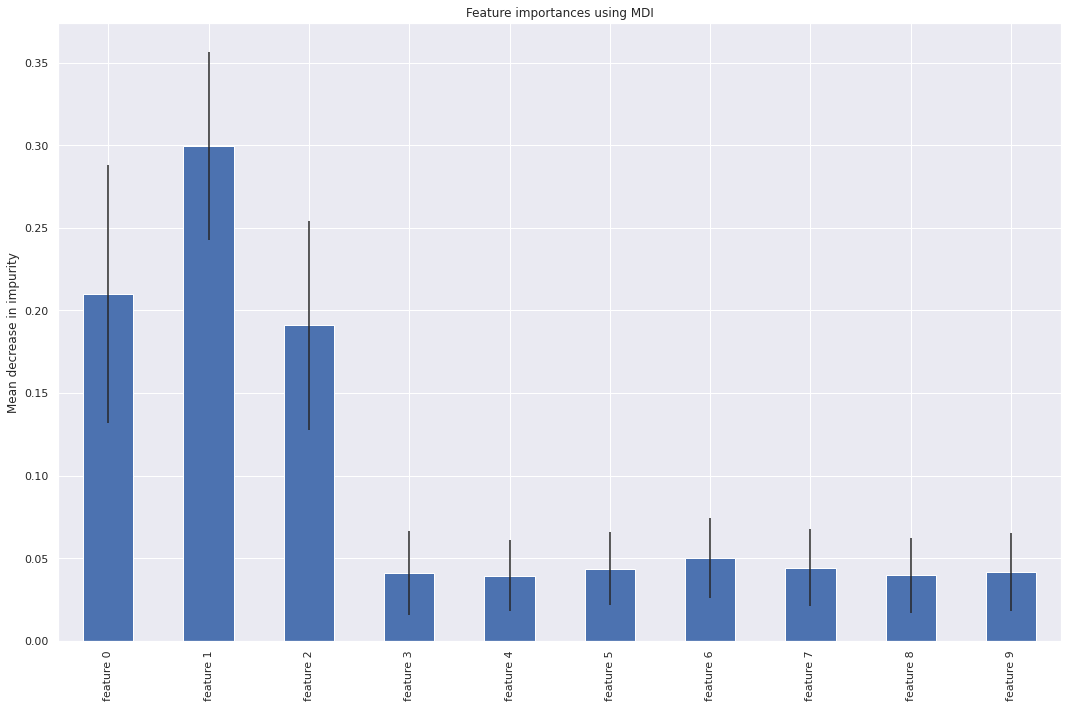

In [8]:
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

# Permutation importance

Permutation feature importance overcomes limitations of the impurity-based feature importance: they do not have a bias toward high-cardinality features and can be computed on a left-out test set.

In [9]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    forest, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

forest_importances = pd.Series(result.importances_mean, index=feature_names)

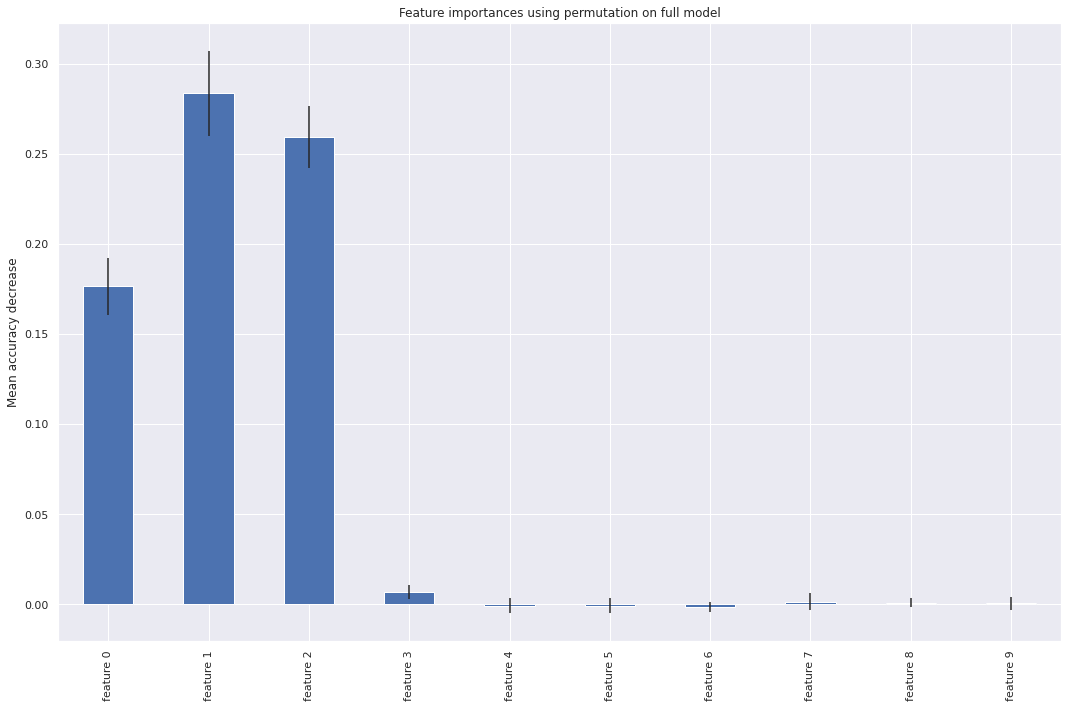

In [10]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

As we see, permutation importance gives lower weights to random high-cardinality features.

# CatBoost: feature importance

In [11]:
from catboost import CatBoostClassifier, Pool

clf = CatBoostClassifier()
clf.fit(X_train, y_train, verbose=False)

In [12]:
feature_importances = clf.get_feature_importance(
    Pool(X_test, y_test, feature_names=feature_names),
    prettified=True,
)
feature_importances

,Feature Id,Importances
0,feature 2,29.841105
1,feature 0,28.984703
2,feature 1,26.378524
3,feature 6,2.266537
4,feature 7,2.224582
5,feature 5,2.214214
6,feature 8,2.135683
7,feature 9,2.113074
8,feature 3,2.072703
9,feature 4,1.768875


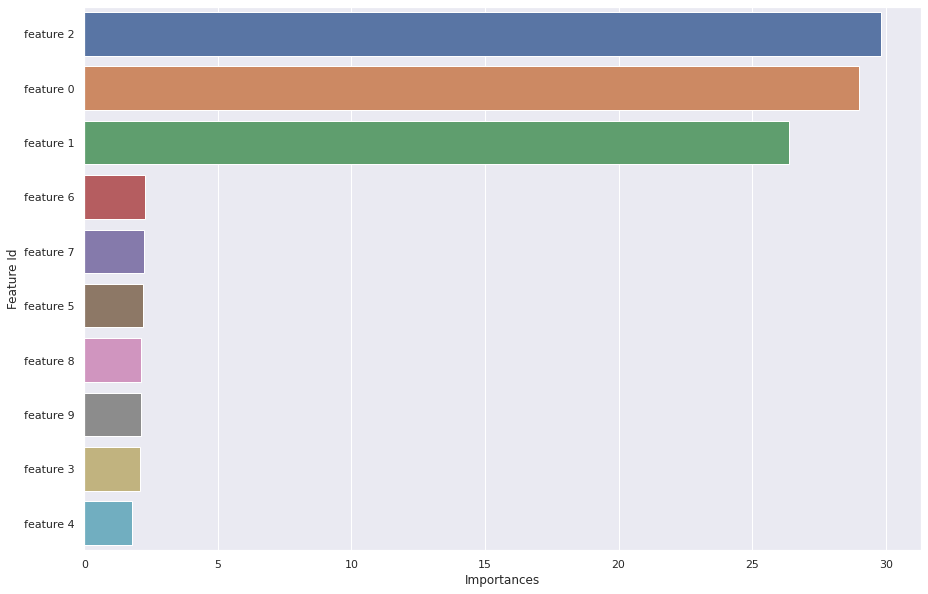

In [13]:
def visualize_feature_importances(clf, pool):
    feature_importances = clf.get_feature_importance(pool, prettified=True)

    sns.barplot(x="Importances", y="Feature Id", data=feature_importances)

visualize_feature_importances(
    clf,
    Pool(X_test, y_test, feature_names=feature_names)
)

# CatBoost: feature interactions

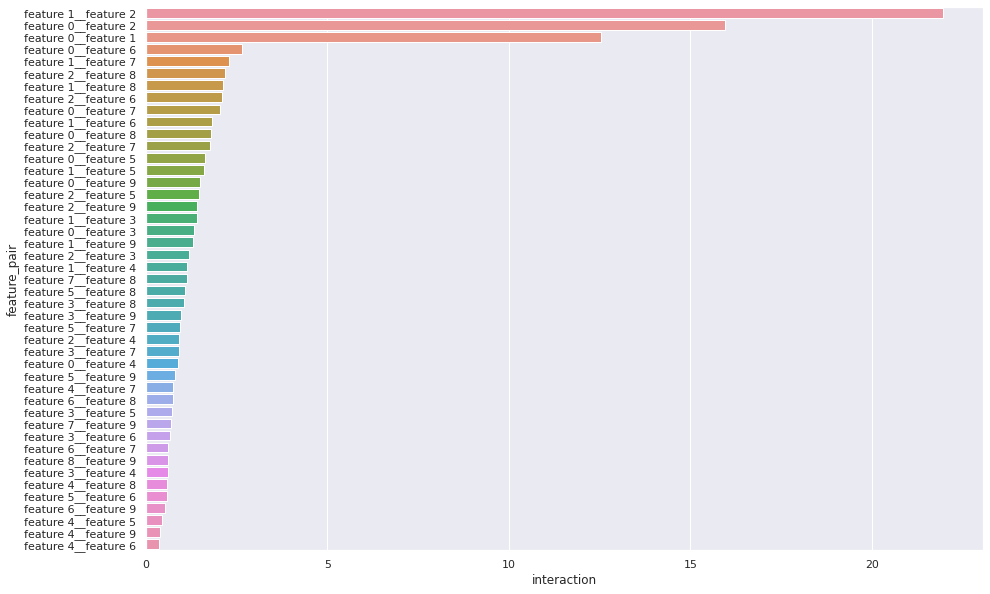

In [14]:
def visualize_feature_interactions(clf, pool, feature_names):
    feature_interactions = clf.get_feature_importance(pool, type="Interaction")

    interactions = []
    feature_pairs = []
    for fi in feature_interactions:
        interactions.append(fi[2])
        feature_pairs.append(feature_names[int(fi[0])] + '__' + feature_names[int(fi[1])])
    feature_interactions_df = pd.DataFrame({
        'interaction': interactions,
        'feature_pair': feature_pairs,
    })

    sns.barplot(x="interaction", y="feature_pair", data=feature_interactions_df)

visualize_feature_interactions(
    clf,
    Pool(X_test, y_test, feature_names=feature_names),
    feature_names
)

# SHAP values

Get the data

In [15]:
df = pd.read_csv('https://raw.githubusercontent.com/horoshenkih/harbour-space-ds210/master/datasets/california_housing_prices.csv')
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [16]:
X = df.drop('median_house_value', axis=1)
y = df.median_house_value
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [17]:
from catboost import CatBoostRegressor
clf = CatBoostRegressor()
clf.fit(X_train, y_train, cat_features=['ocean_proximity'], verbose=False, plot=False)

SHAP algorithm is implemented in `shap` package.

It works witn CatBoost and supports categorical features.

In [18]:
import shap

In [19]:
explainer = shap.TreeExplainer(clf)
pool_test = Pool(X_test, y_test, cat_features=['ocean_proximity'])
shap_values = explainer.shap_values(pool_test)

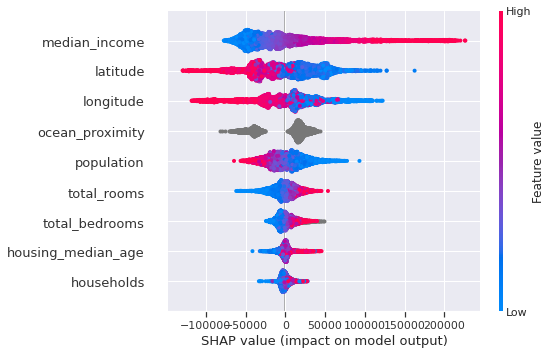

In [20]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_test)

Look at an individual sample

In [21]:
shap.initjs()

sample_idx = 1000
shap.force_plot(explainer.expected_value, shap_values[sample_idx,:], X_test.iloc[sample_idx,:])

# Masking and occlusion

In [22]:
from sklearn.datasets import fetch_20newsgroups

dataset = fetch_20newsgroups(
    subset="all",
    remove=('headers', 'footers', 'quotes'),
    categories=("sci.space", "rec.autos", "talk.politics.misc", "comp.graphics")
)

texts = dataset.data
y = dataset.target

In [23]:
texts_train, texts_test, y_train, y_test = train_test_split(texts, y, test_size=0.5, random_state=1)

In [24]:
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

clf = Pipeline([
    ("vec", TfidfVectorizer(stop_words="english")),
    ("clf", SGDClassifier(alpha=.0001, max_iter=50, loss="log", random_state=0)),
])

clf.fit(texts_train, y_train)

Pipeline(steps=[('vec', TfidfVectorizer(stop_words='english')),
                ('clf',
                 SGDClassifier(loss='log', max_iter=50, random_state=0))])

In [25]:
def compute_token_importance(clf, text):
    from scipy.linalg import norm
    # a simple tokenizer: split by whitespace
    # not necessarily the same tokenizer that the vectorizer uses!
    import re
    tokens = re.split(r'\W+', text.strip())
    initial_text = " ".join(tokens)
    # predict the probabilities of all classes for the initial text
    initial_class_distribution = clf.predict_proba([initial_text])[0]
    token_importances = []
    for i, token in enumerate(tokens):
        masked_tokens = tokens[:]
        # mask (remove) one token
        masked_tokens[i] = "<UNKNOWN>"
        masked_text = " ".join(masked_tokens)
        # classify the text with masked token
        masked_class_distribution = clf.predict_proba([masked_text])[0]
        # token importance is the distance between
        # the initial distribution of classes
        # and the distribution after removal of the token
        token_importance = norm(initial_class_distribution - masked_class_distribution)
        token_importances.append((token, token_importance))
    return token_importances

# remember the initial categories in the dataset
print("categories:", ", ".join(dataset.target_names))
for text, label in zip(texts_test[:20], y_test[:20]):
    display(HTML("<hr>"))
    display(HTML(dataset.target_names[label]))  # uncomment this line to see the true label
    token_importances = compute_token_importance(clf, text)
    display_token_importance(token_importances)
    display(HTML("<hr>"))

categories: comp.graphics, rec.autos, sci.space, talk.politics.misc


# Visualizing layer activations in ConvNets

Get images of some cute animals.

In [26]:
import torchvision

In [27]:
data = torchvision.datasets.OxfordIIITPet(
    root="./data",
    download=True,
    transform=torchvision.transforms.ToTensor(),
)

  0%|          | 0/791918971 [00:00<?, ?it/s]

Extracting data/oxford-iiit-pet/images.tar.gz to data/oxford-iiit-pet


  0%|          | 0/19173078 [00:00<?, ?it/s]

Extracting data/oxford-iiit-pet/annotations.tar.gz to data/oxford-iiit-pet


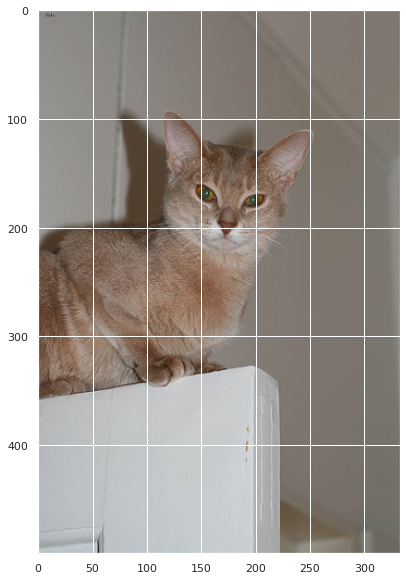

In [28]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import numpy as np

image_index = 31
img = data[image_index][0]
plt.imshow(np.asarray(F.to_pil_image(img)))

Load pre-trained ResNet model and check that it works as expected

In [29]:
from torchvision.io import read_image
from torchvision.models import resnet50, ResNet50_Weights

# Step 1: Initialize model with the best available weights
weights = ResNet50_Weights.DEFAULT
model = resnet50(weights=weights)
model.eval()

# Step 2: Initialize the inference transforms
preprocess = weights.transforms()

# Step 3: Apply inference preprocessing transforms
batch = preprocess(img).unsqueeze(0)

# Step 4: Use the model and print the predicted category
prediction = model(batch).squeeze(0).softmax(0)
class_id = prediction.argmax().item()
score = prediction[class_id].item()
category_name = weights.meta["categories"][class_id]
print(f"{category_name}: {100 * score:.1f}%")

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Egyptian cat: 19.3%


PyTorch provides tools for model inspection: `get_graph_node_names` and `create_feature_extractor`

In [30]:
from torchvision.models.feature_extraction import get_graph_node_names, create_feature_extractor
train_nodes, eval_nodes = get_graph_node_names(model)
eval_nodes[:10]

['x',
 'conv1',
 'bn1',
 'relu',
 'maxpool',
 'layer1.0.conv1',
 'layer1.0.bn1',
 'layer1.0.relu',
 'layer1.0.conv2',
 'layer1.0.bn2']

Extract the output of the first ReLU. Check that there are sparse activations.

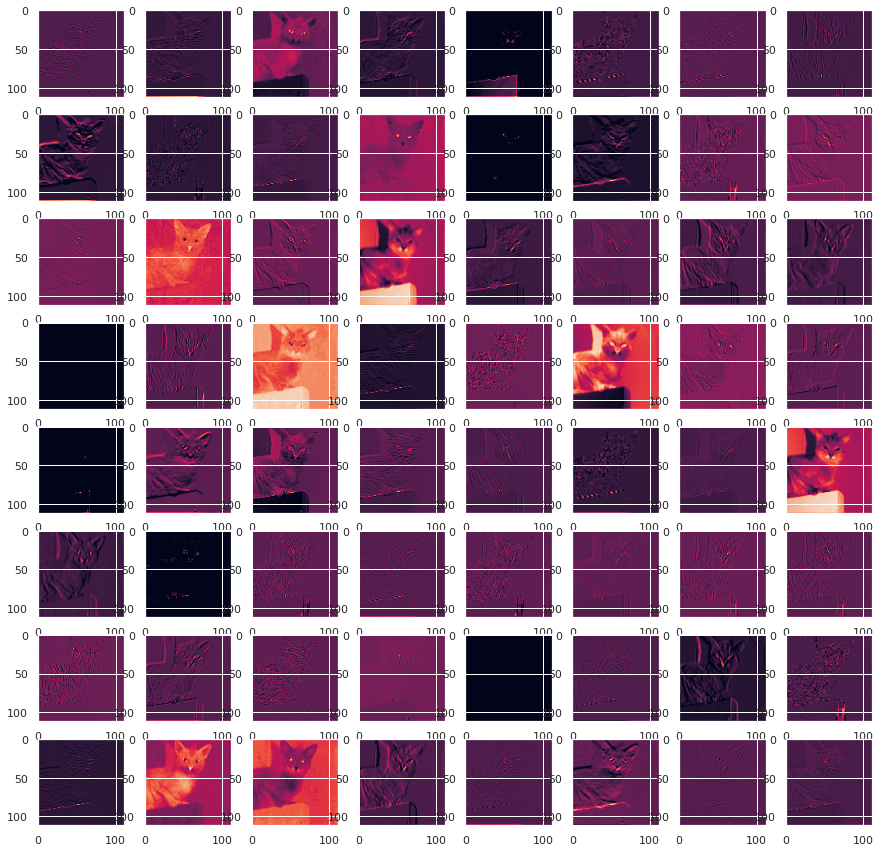

In [31]:
extract_relu = create_feature_extractor(model, {'relu': 'layer1'})
img2 = extract_relu(batch)['layer1']

fig, ax = plt.subplots(8, 8, figsize=(15,15))
ax = ax.ravel()
for i in range(img2.shape[1]):
    ax[i].imshow(img2[0][i].detach().numpy())
plt.show()

Compare with uninitialized model - without training, all activations are dense

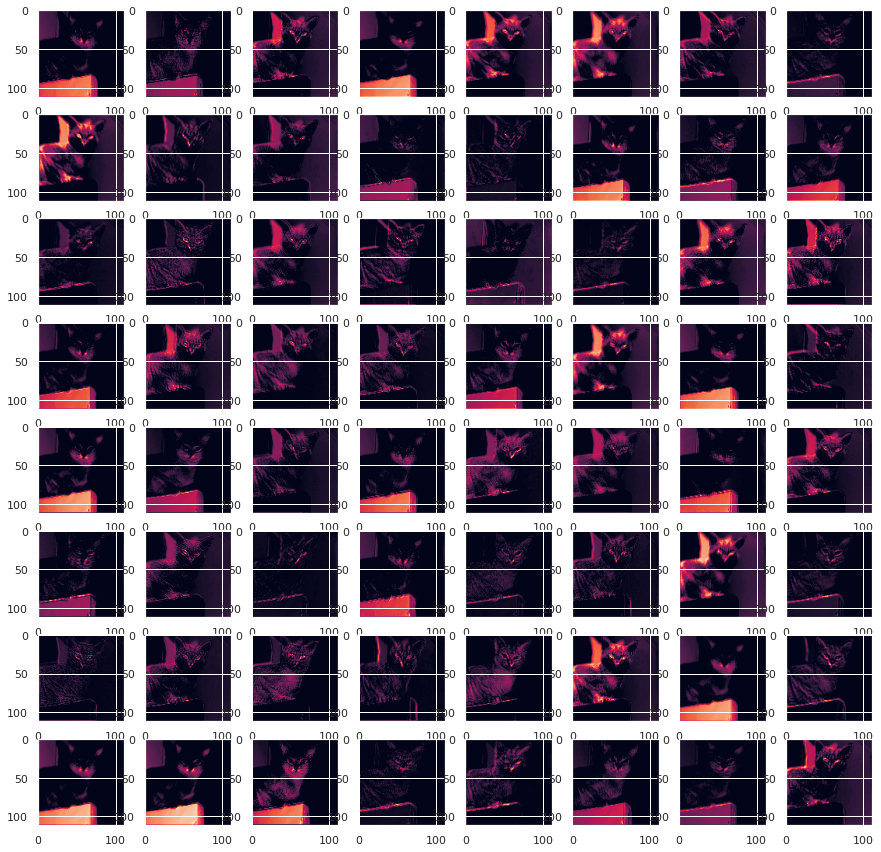

In [32]:
extract_relu = create_feature_extractor(resnet50(), {'relu': 'layer1'})
img2 = extract_relu(batch)['layer1']

fig, ax = plt.subplots(8, 8, figsize=(15,15))
ax = ax.ravel()
for i in range(img2.shape[1]):
    ax[i].imshow(img2[0][i].detach().numpy())
plt.show()

# Home Assignment 10

In this assignment, you will work with probably the most famous and well-studied dataset.

Your task is to predict the value of `Survived` column (binary classification).

You can read more about the data here: https://www.kaggle.com/c/titanic/data

In [74]:
df = pd.read_csv("https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Exercise 1 (2 points)

Create training dataset, train CatBoost model and **find feature importances** for all features. You need to decide which columns to use as features. Feel free to do feature engineering.

In [71]:
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split

df = df.dropna()
df = pd.get_dummies(df, columns=["Sex", "Embarked"])

features = ["Pclass", "Age", "SibSp", "Parch", "Fare", "Sex_female", "Sex_male", "Embarked_C", "Embarked_Q", "Embarked_S"]

X_train, X_test, y_train, y_test = train_test_split(df[features], df["Survived"], test_size=0.2)

clf = CatBoostClassifier()
clf.fit(X_train, y_train,verbose = False)

y_pred = clf.predict(X_test)

feature_importances = clf.get_feature_importance(
    prettified=True,
)
feature_importances


,Feature Id,Importances
0,Sex_male,23.383944
1,Sex_female,19.934067
2,Age,18.870896
3,Fare,15.614537
4,Parch,7.184526
5,SibSp,6.531023
6,Embarked_C,3.096102
7,Pclass,2.696546
8,Embarked_S,2.561844
9,Embarked_Q,0.126515


## Exercise 2 (2 points)

Compute feature interactions.



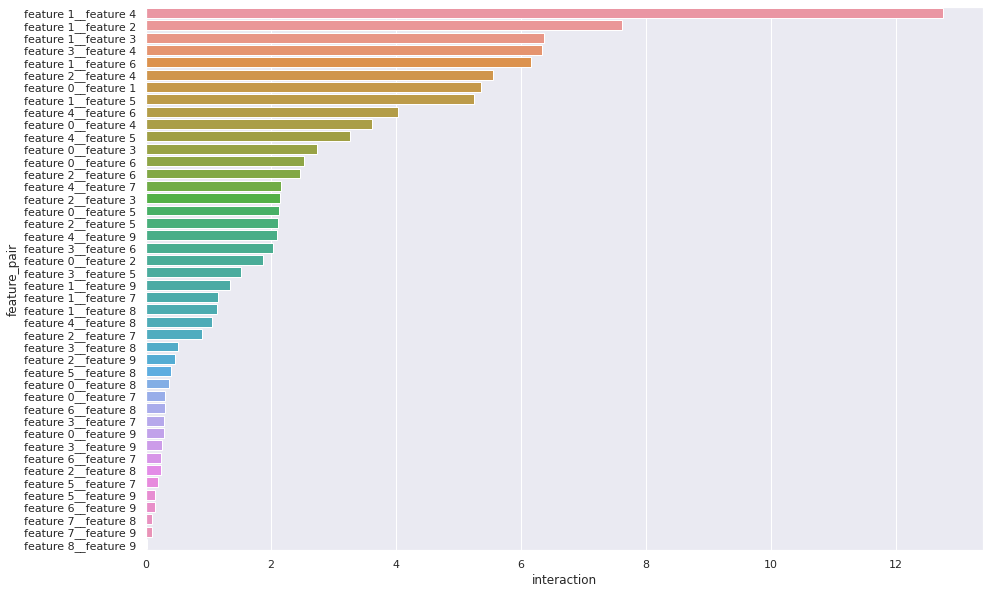

In [73]:
feature_interactions = clf.get_feature_importance(type="Interaction")
interactions = []
feature_pairs = []
for fi in feature_interactions:
    interactions.append(fi[2])
    feature_pairs.append(feature_names[int(fi[0])] + '__' + feature_names[int(fi[1])])
feature_interactions_df = pd.DataFrame({
    'interaction': interactions,
    'feature_pair': feature_pairs,
})
sns.barplot(x="interaction", y="feature_pair", data=feature_interactions_df)

## Exercise 3 (2 points)

Compute SHAP values. Use `shap.summary_plot`. Interpret the results.

In [79]:
# YOUR CODE HERE
import shap
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test, y_test)

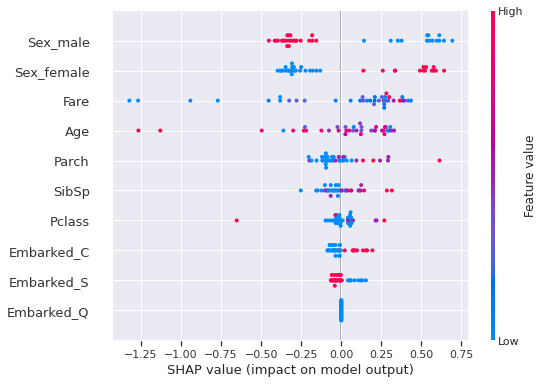

In [80]:
shap.summary_plot(shap_values, X_test)

**As we can see in SHAP plot, we can see the chance of survival for women is higher. Moreover, the ones who paid higher fare had higher chance of survival.
we can see people with middle age have more chance of survival.**